In [1]:
import shutil
from pathlib import Path
import matplotlib as mpl, importlib.util, pathlib, scienceplots  # noqa

pkg_file = importlib.util.find_spec("scienceplots").origin
styles_dir = pathlib.Path(pkg_file).parent / "styles"

user_stylelib = Path(mpl.get_configdir()) / "stylelib"
user_stylelib.mkdir(parents=True, exist_ok=True)

for f in styles_dir.glob("*.mplstyle"):
    shutil.copy2(f, user_stylelib / f.name)

mpl.style.reload_library()
print("'science' in mpl.style.available?", 'science' in mpl.style.available)

'science' in mpl.style.available? True


In [ ]:
import sys
sys.path.insert(0, "/Users/yasin/code/CANDEL/")

from os.path import join, exists 

import numpy as np
from h5py import File


import sys, matplotlib as mpl, matplotlib.pyplot as plt
import scienceplots            # <-- registers the styles
import importlib
import pathlib

import matplotlib.pyplot as plt
# pkg_file = importlib.util.find_spec("scienceplots").origin
# pkg_dir = pathlib.Path(pkg_file).parent
# styles_dir = pkg_dir / "styles"
# plt.style.use(str(styles_dir / "science.mplstyle"))

import candel
from candel import plot_corner_from_hdf5, read_samples, read_gof
from utils import * 
from candel.util import radec_to_galactic
from candel.cosmography import Redshift2Distance
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

style_dir = pathlib.Path(importlib.util.find_spec("scienceplots").origin).parent / "styles"
plt.style.use("science")


COLS = ["#87193d", "#1e42b9", "#d42a29", "#05dd6b", "#ee35d5"]

config_path = "/Users/yasin/code//CANDEL/scripts/runs/config.toml"
config = candel.load_config(config_path, )
root = join("/Users/yasin/code/CANDEL/", "final/", "")
print(root)

figures_folder = "/Users/yasin/Dropbox/Apps/Overleaf/Cluster Anisotropies/Figures/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/yasin/code/CANDEL/final/


### Redshift distribution

In [16]:
config_path =  '/Users/yasin/code/CANDEL/tariq_notebooks/paper_Clusters/data.toml'
data = candel.pvdata.load_PV_dataframes(config_path)
model = candel.model.ClustersModel(config_path,)
model_kwargs = {'data':data,}

2025-11-10 14:48:22 loading 1 PV dataframes: ['Clusters']
2025-11-10 14:48:22 loading existing LOS data from /Users/yasin/code/CANDEL/data/Clusters/los_Clusters_Carrick2015.hdf5.
2025-11-10 14:48:22 initially loaded 312 clusters.
2025-11-10 14:48:22 converting clusters' redshifts to the CMB frame.
2025-11-10 14:48:22 removed 0 clusters, thus 312 remain.
2025-11-10 14:48:22 subtracting the mean logT from the data.
2025-11-10 14:48:22 setting the LOS radial grid from 0.1 to 1001 with 251 points.
2025-11-10 14:48:22 setting los_decay_scale to 5.0
2025-11-10 14:48:22 marginalising over 1 field realisations.
2025-11-10 14:48:23 precomputing Vext_per_pix data for nside = 1.
2025-11-10 14:48:23 precomputing Vext_radial_binned data with bin edges (comoving Mpc): [0, 250, 500, 1000].


/Users/yasin/code/CANDEL/candel/pvdata/data.py:1426: RuntimeWarning: invalid value encountered in log10
  logY = np.log10(Y_arcmin2)


2025-11-10 14:48:23 marginalizing eta with k_sigma = 5 and n_grid = 31 (if TFR).


[np.float64(1e-05), np.float64(0.08157662482886263), np.float64(0.16653208188137847), np.float64(0.25541783290740305), np.float64(0.34885570321455106), np.float64(0.44754859659659657)] [   0.  240.  480.  720.  960. 1200.]


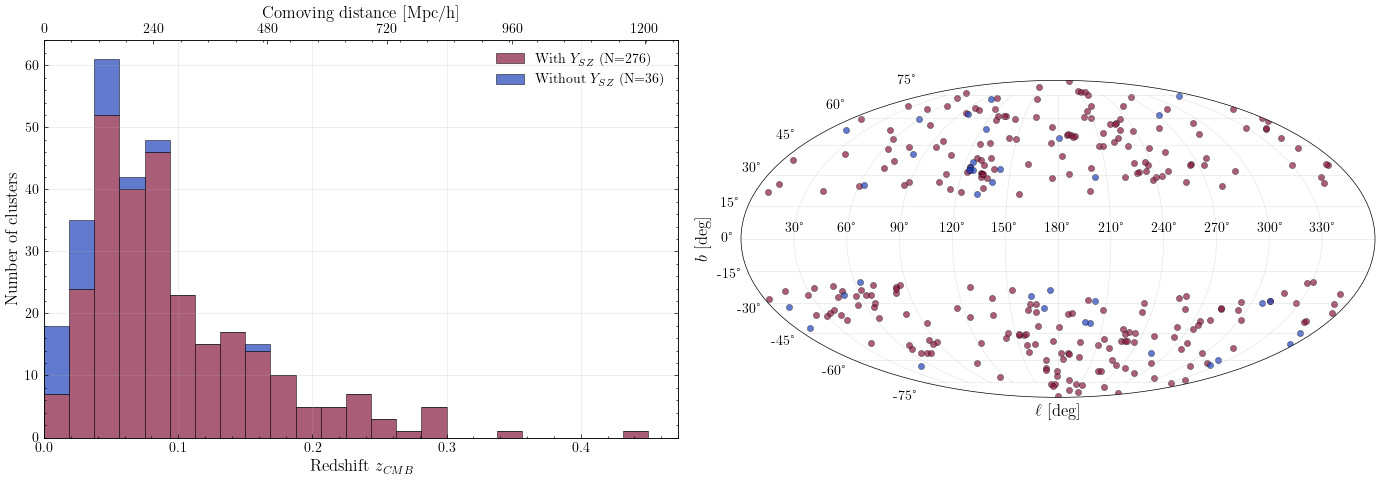

In [ ]:

r2d = Redshift2Distance()

# Create figure with two subplots - one normal, one with Mollweide projection
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)  # Left panel: regular histogram
ax2 = fig.add_subplot(122, projection='mollweide')  # Right panel: Mollweide

# Get data from PVDataFrame
zcmb = data.data['zcmb']
Y = data.data['Y']
RA = data.data['RA']
DEC = data.data['dec']

# Convert RA, DEC to galactic coordinates
ell, b = radec_to_galactic(RA, DEC)

# Split by Y_SZ availability
has_Y = Y > 0
no_Y = Y < 0

# Left panel: Stacked histogram showing both populations
bins = np.linspace(0, 0.45, 25)
counts_no_Y, bin_edges = np.histogram(zcmb[no_Y], bins=bins)
counts_has_Y, _ = np.histogram(zcmb[has_Y], bins=bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
width = bin_edges[1] - bin_edges[0]

ax1.bar(bin_centers, counts_has_Y, width=width, alpha=0.7, 
        label=f'With $Y_{{SZ}}$ (N={np.sum(has_Y)})', 
        color=COLS[0], edgecolor='black', linewidth=0.5)
ax1.bar(bin_centers, counts_no_Y, width=width, alpha=0.7, 
        bottom=counts_has_Y,
        label=f'Without $Y_{{SZ}}$ (N={np.sum(no_Y)})', 
        color=COLS[1], edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Redshift $z_{CMB}$', fontsize=12)
ax1.set_ylabel('Number of clusters', fontsize=12)
ax1.set_xlim(left=0.0)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Add secondary x-axis for comoving distance
ax1_top = ax1.twiny()
# Function to convert redshift to comoving distance in Mpc/h (h=1)
def z_to_dist(z):
    return r2d(z, h=1.0)

def dist_to_z(d):
    # Approximate inverse (for tick positioning)
    # Create a lookup for common distances
    z_test = np.linspace(1e-5, 0.5, 1000)
    d_test = r2d(z_test, h=1.0)
    return np.interp(d, d_test, z_test)

# Set the limits to match ax1
ax1_top.set_xlim(ax1.get_xlim())

# Get current x-axis limits in redshift
d_min, d_max = z_to_dist(np.array([1e-5, 0.5]))

# Create nice tick positions in comoving distance
d_ticks = np.linspace(0, int(d_max/200)*200, 6)  # Round to nice values
z_ticks = [dist_to_z(d) for d in d_ticks]

print(z_ticks, d_ticks)

ax1_top.set_xticks(z_ticks)
ax1_top.set_xticklabels([f'{int(d)}' for d in d_ticks])
ax1_top.set_xlabel('Comoving distance [Mpc/h]', fontsize=12)

# Right panel: Sky distribution in Mollweide projection (galactic coordinates)
# Convert galactic coordinates to radians, centered at 180 deg for Mollweide
# Mollweide projection expects longitude centered at 0 (which we'll label as 180)
ell_centered = np.where(ell > 180, ell - 360, ell)
ell_rad = np.deg2rad(ell_centered)
b_rad = np.deg2rad(b)

# Plot both populations
ax2.scatter(ell_rad[has_Y], b_rad[has_Y], s=20, alpha=0.7, 
            color=COLS[0], edgecolors='black', linewidths=0.3,
            label=f'With $Y_{{SZ}}$ (N={np.sum(has_Y)})')
ax2.scatter(ell_rad[no_Y], b_rad[no_Y], s=20, alpha=0.7, 
            color=COLS[1], edgecolors='black', linewidths=0.3,
            label=f'Without $Y_{{SZ}}$ (N={np.sum(no_Y)})')

ax2.set_xlabel('$\\ell$ [deg]', fontsize=12)
ax2.set_ylabel('$b$ [deg]', fontsize=12)

# Set custom tick labels to show 0-360 degrees
# Mollweide x-axis goes from -π to π, which we map to 0-360
tick_locs = np.array([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
tick_labels = [(loc + 180) % 360 for loc in tick_locs]
ax2.set_xticks(np.deg2rad(tick_locs))
ax2.set_xticklabels([f'{int(label)}°' for label in tick_labels])

ax2.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig(join(figures_folder, 'redshift.pdf'), dpi=300)

plt.show()




In [60]:
figures_folder

'/Users/yasin/Dropbox/Apps/Overleaf/Cluster Anisotropies/Figures/'

### Posterior summary

In [11]:
fname = join(root, "precomputed_los_precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole_linear.hdf5")
# fname = join(root, "precomputed_los_precomputed_los_Carrick2015_2MTF_MNR_zeropoint_dipole.hdf5")
# fname = "/Users/rstiskalek/Projects/CANDEL/results/dH0/precomputed_los_precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole_UnifComponents.hdf5"
# fname = "/Users/rstiskalek/Projects/CANDEL/results/dH0/precomputed_los_precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole_bad_photo_too.hdf5"

with File(fname, "r") as f:
    grp = f["samples"]
    # print(f"keys: {list(grp.keys())}")

    # for key in grp.keys():
        # print(f"{key}: {np.median(grp[key][...])}")

    samples = {key: grp[key][...] for key in grp.keys()}


keys_read = ["zeropoint_dipole_mag", "zeropoint_dipole_ell", "zeropoint_dipole_b", "dH0"]
# keys_read = ["sigma_int"]
# keys_read = ["zeropoint_dipole_mag", "dH0"]
# keys_read = ['M_dipole_b', 'M_dipole_ell', 'M_dipole_mag']
# keys_read = ['Vext_b', 'Vext_ell', 'Vext_mag']

# samples["dH0"] = 10**(samples["M_dipole_mag"] / 5) - 1

for key in keys_read:
    if key == "dH0":
        x = 10**(samples["zeropoint_dipole_mag"] / 5) - 1
    else:
        x = samples[key]

    low, med, high = np.percentile(x, [16, 50, 84])
    low = med - low
    high = high - med
    print(f"{key}: {med:.3f} +{high:.3f} -{low:.3f}")


logZ = compare_zeropoint_dipole_gof(fname, "logZ_harmonic")
print(f"logZ_harmonic: {logZ:.3f}")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/yasin/code/CANDEL/results/precomputed_los_precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole_linear.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [21]:
with open(join("/Users/yasin/code/CANDEL/scripts/runs", "tasks_0.txt")) as f:
    fnames = [line.strip().split(" ")[1] for line in f if line.strip()]
    fnames = [fname.replace(".toml", ".hdf5") for fname in fnames]
print(fnames)

['/Users/yasin/code/CANDEL/results/friday/Carrick2015_Clusters_noMNR_LTYT_hasY.hdf5', '/Users/yasin/code/CANDEL/results/friday/Carrick2015_Clusters_noMNR_LTYT_dipA_hasY.hdf5']


In [20]:
for fname in fnames:
    if 'Carrick2015' not in fname:
        continue
    print(fname.split("/")[-1].split(".hdf5")[0])
    gof = read_gof(fname, "logZ_harmonic")
    print(gof)


Carrick2015_Clusters_noMNR_LTYT_hasY
-1175.968623485146
Carrick2015_Clusters_noMNR_LTYT_dipA_hasY
-1175.2385082990165


In [19]:
# ===== CONFIG: stems -> pretty names (no numbering) =====
pretty_name_map = {
    "manticore_Clusters_noMNR_LTYT_hasY":                r"No flow or $H_0$ variation",
    "manticore_Clusters_noMNR_LTYT_dipVext_hasY":        r"$\mathbf{V}_{\rm ext}$ dipole",
    "manticore_Clusters_noMNR_LTYT_quadVext_hasY":       r"$\mathbf{V}_{\rm ext}$ quadrupole",
    "manticore_Clusters_noMNR_LTYT_pixVext_hasY":        r"$\mathbf{V}_{\rm ext}$ pixelised",
    "manticore_Clusters_noMNR_LTYT_radVext_hasY":        r"$\mathbf{V}_{\rm ext}$ radially varying dipole",
    "manticore_Clusters_noMNR_LTYT_dipA_hasY":           r"$H_0$ dipole",
    "manticore_Clusters_noMNR_LTYT_quadA_hasY":          r"$H_0$ quadrupole",
    "manticore_Clusters_noMNR_LTYT_pixA_hasY":           r"$H_0$ pixelised",
    "manticore_Clusters_noMNR_LTYT_dipVext_dipA_hasY":   r"$H_0$ dipole + $\mathbf{V}_{\rm ext}$ dipole",
}

row_order = [
    "manticore_Clusters_noMNR_LTYT_hasY",
    "manticore_Clusters_noMNR_LTYT_dipVext_hasY",
    "manticore_Clusters_noMNR_LTYT_quadVext_hasY",
    "manticore_Clusters_noMNR_LTYT_pixVext_hasY",
    "manticore_Clusters_noMNR_LTYT_radVext_hasY",
    "manticore_Clusters_noMNR_LTYT_dipA_hasY",
    "manticore_Clusters_noMNR_LTYT_quadA_hasY",
    "manticore_Clusters_noMNR_LTYT_pixA_hasY",
    "manticore_Clusters_noMNR_LTYT_dipVext_dipA_hasY",
]

# ===== collect stats from files =====
import os, math

def stem_from_fname(fname: str) -> str:
    return os.path.basename(fname).split(".hdf5")[0]

def safe_get(fname, key):
    try:
        return read_gof(fname, key)
    except Exception:
        return None

stats = {}
for fname in fnames:
    if "manticore" not in fname:
        continue
    stem = stem_from_fname(fname)
    if stem not in pretty_name_map:
        continue
    stats[stem] = {
        "lnZ_harmonic":     safe_get(fname, "lnZ_harmonic"),
        "err_lnZ_harmonic": safe_get(fname, "err_lnZ_harmonic"),
        "lnZ_laplace":      safe_get(fname, "lnZ_laplace"),
        "err_lnZ_laplace":  safe_get(fname, "err_lnZ_laplace"),
        "BIC":              safe_get(fname, "BIC"),
    }

# ----- baseline (reference is lnZ_harmonic of the baseline model) -----
baseline_stem = "manticore_Clusters_noMNR_LTYT_hasY"
zb  = stats[baseline_stem].get("lnZ_harmonic")
ezb = stats[baseline_stem].get("err_lnZ_harmonic")

# ===== helpers =====
def pm_two_dec(val, err=None):
    if val is None:
        return r"\textemdash"
    if err is None:
        return f"{val:.2f}"
    return f"{val:.2f} $\\pm$ {err:.2f}"

def quadrature(a, b):
    if a is None and b is None:
        return None
    a = 0.0 if a is None else a
    b = 0.0 if b is None else b
    return math.sqrt(a*a + b*b)

# ===== build LaTeX table (all referenced to baseline lnZ_harm) =====
header = r"""\begin{table}
\centering
\caption{Relative goodness-of-fit referenced to the baseline model (``No flow or $H_0$ variation''). We report $\Delta\ln Z_{\rm harm} \equiv \ln Z_{\rm harm}-\ln Z_{\rm harm}^{\rm (base)}$, $\Delta\ln Z_{\rm Laplace} \equiv \ln Z_{\rm Laplace}-\ln Z_{\rm harm}^{\rm (base)}$, and $\Delta\ln Z_{\rm BIC}$ where $\ln Z_{\rm BIC}\equiv -\tfrac{1}{2}\,{\rm BIC}$, also referenced to $\ln Z_{\rm harm}^{\rm (base)}$. Uncertainties are shown where available.}
\begin{tabular}{lccc}
\hline
Model & $\Delta\ln Z_{\rm harm}$ & $\Delta\ln Z_{\rm Laplace}$ & $\Delta\ln Z_{\rm BIC}$ \\
\hline
"""

rows = []
for stem in row_order:
    name = pretty_name_map.get(stem, stem.replace("_", r"\_"))
    s = stats.get(stem, {})

    # Δ lnZ_harm
    z  = s.get("lnZ_harmonic")
    ez = s.get("err_lnZ_harmonic")
    dlh  = (None if (z is None or zb is None) else (z - zb))
    sdlh = (None if (ez is None and ezb is None) else quadrature(ez, ezb))

    # Δ lnZ_Laplace (still referenced to baseline lnZ_harm)
    zl  = s.get("lnZ_laplace")
    ezl = s.get("err_lnZ_laplace")
    dll  = (None if (zl is None or zb is None) else (zl - zb))
    sdll = (None if (ezl is None and ezb is None) else quadrature(ezl, ezb))

    # Δ lnZ_BIC: lnZ_BIC = -BIC/2; reference to baseline lnZ_harm
    bic = s.get("BIC")
    lnZ_BIC = (None if bic is None else (-0.5 * bic))
    dlbic = (None if (lnZ_BIC is None or zb is None) else (lnZ_BIC - zb))
    # no quoted uncertainty for BIC -> show value only
    row = " & ".join([
        name,
        pm_two_dec(dlh,  sdlh),
        pm_two_dec(dll,  sdll),
        pm_two_dec(dlbic, None),
    ]) + r" \\"
    rows.append(row)

footer = r"""\hline
\end{tabular}
\label{tab:gof_relative_bic}
\end{table*}
"""

latex_table = header + "\n".join(rows) + "\n" + footer
print(latex_table)

KeyError: 'manticore_Clusters_noMNR_LTYT_hasY'

### Figure: Main posterior for dipoles and no flow model

['/Users/yasin/code/CANDEL/results/friday/manticore_Clusters_noMNR_LTYT_hasY.hdf5', '/Users/yasin/code/CANDEL/results/friday/manticore_Clusters_noMNR_LTYT_dipVext_hasY.hdf5', '/Users/yasin/code/CANDEL/results/friday/manticore_Clusters_noMNR_LTYT_dipA_hasY.hdf5']
manticore_Clusters_noMNR_LTYT_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, alpha, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v
manticore_Clusters_noMNR_LTYT_dipVext_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, alpha, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v
manticore_Clusters_noMNR_LTYT_dipA_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, alpha, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v, zeropoint_dipole_b, zeropoint_dipole_ell, zeropoint_dipole_mag
Removed no burn in
Removed no burn in
Removed no burn in


/Users/yasin/code/CANDEL/candel/util.py:756: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


2025-10-24 18:22:36 [INFO] Saving GetDist triangle plot to: /Users/yasin/Downloads/main_posterior.pdf


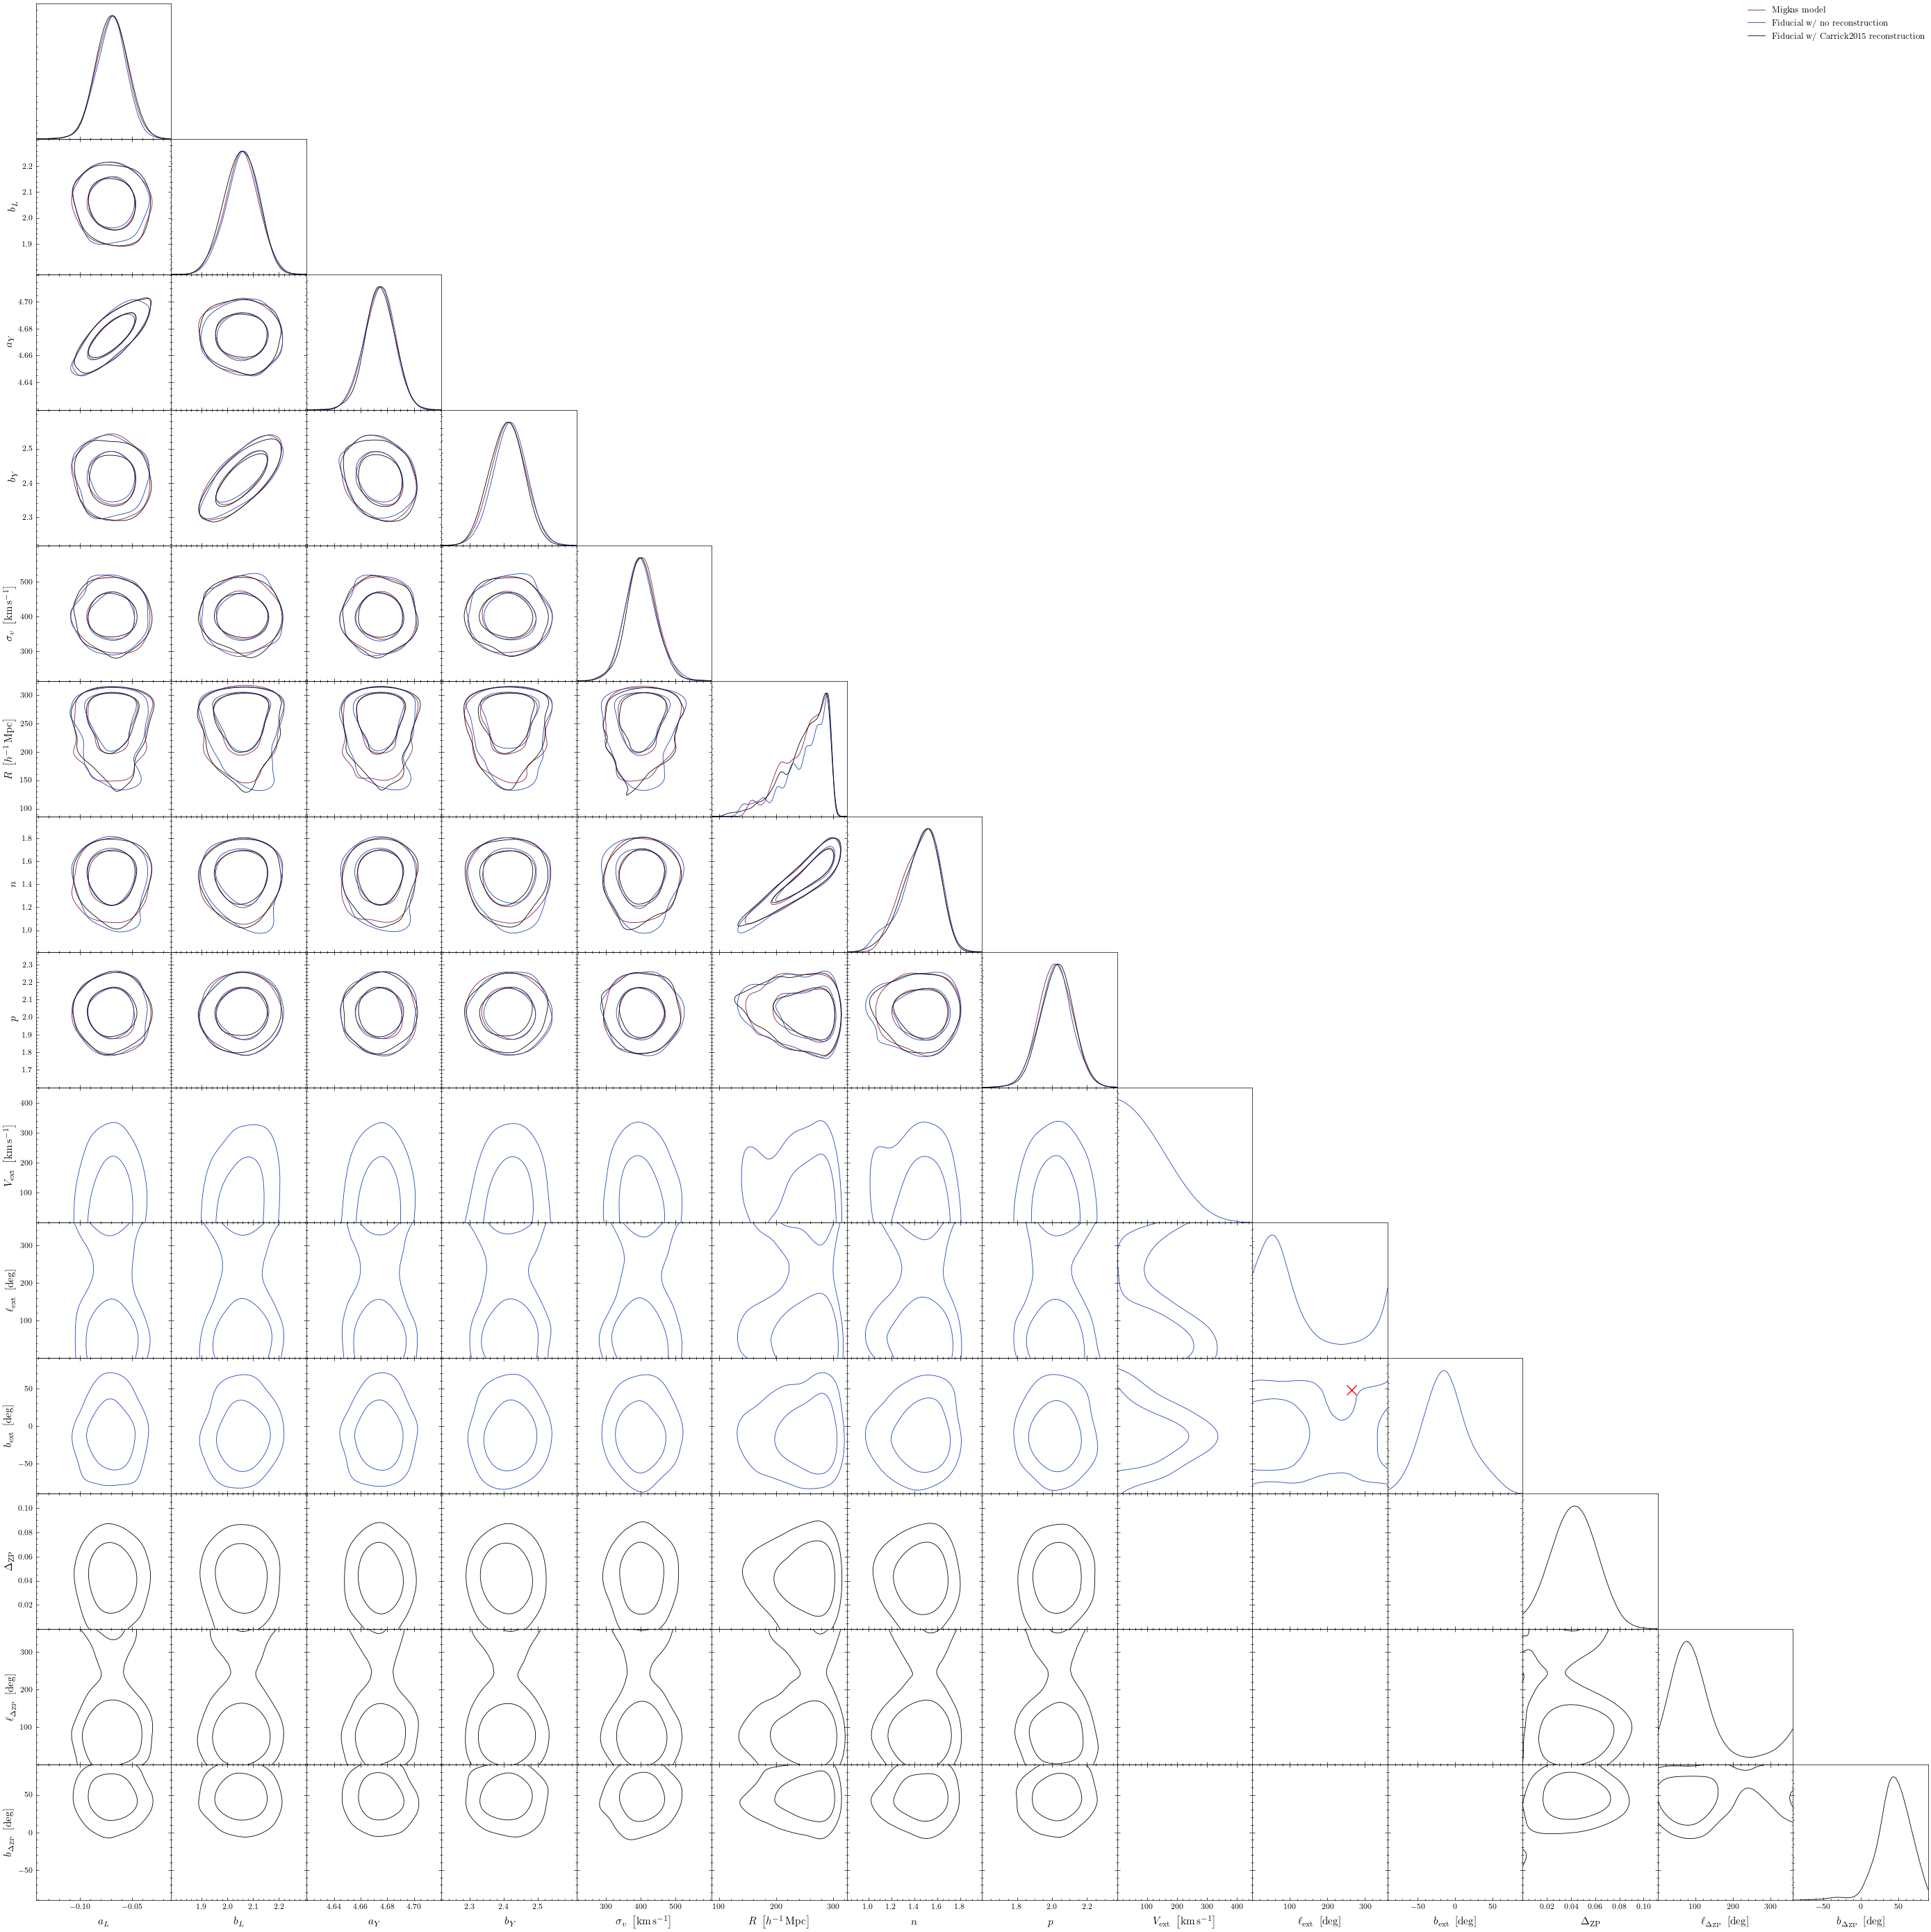

In [2]:



fnames = [
    "friday/manticore_Clusters_noMNR_LTYT_hasY.hdf5",
    "friday/manticore_Clusters_noMNR_LTYT_dipVext_hasY.hdf5",
    "friday/manticore_Clusters_noMNR_LTYT_dipA_hasY.hdf5",
    ]


keys = ['A_CL','B_CL','A2_CL', 'B2_CL', 'sigma', 'sigma2' 'rho12', 'sigma_v', 
        'R_dist_emp','n_dist_emp', 'p_dist_emp',
        'Vext_mag','Vext_ell', 'Vext_b',
        'zeropoint_dipole_mag', 'zeropoint_dipole_ell', 'zeropoint_dipole_b',
        ]

cols = [
    COLS[0],COLS[1],
    "k",
    ]

labels = [
    "Migkas model",
    "Fiducial w/ no reconstruction",
    "Fiducial w/ Carrick2015 reconstruction",
    ]

fnames = [join(root, f) for f in fnames]

points = {("Vext_ell", "Vext_b"): (264., 48.),}

print(fnames)
plot_corner_from_hdf5(
    fnames,
    labels=labels,
    cols=cols,
    filled=False,
    points=points,
    keys=keys,
    filename="/Users/yasin/Downloads/main_posterior.pdf",
    legend_fontsize=40,
    )

### Figure: Compare MNR and uniform marginalisation


['/Users/yasin/code/CANDEL/results/friday/Carrick2015_Clusters_MNR_LTYT_dipVext_hasY.hdf5', '/Users/yasin/code/CANDEL/results/friday/Carrick2015_Clusters_noMNR_LTYT_dipVext_hasY.hdf5']
Carrick2015_Clusters_MNR_LTYT_dipVext_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, alpha, beta, logT_latent, logT_prior_mean, logT_prior_std, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v
Carrick2015_Clusters_noMNR_LTYT_dipVext_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, alpha, beta, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v
Removed no burn in
Removed no burn in


/Users/yasin/code/CANDEL/candel/util.py:756: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


2025-10-24 18:24:46 [INFO] Saving GetDist triangle plot to: /Users/yasin/Downloads/migkas_comparison.pdf


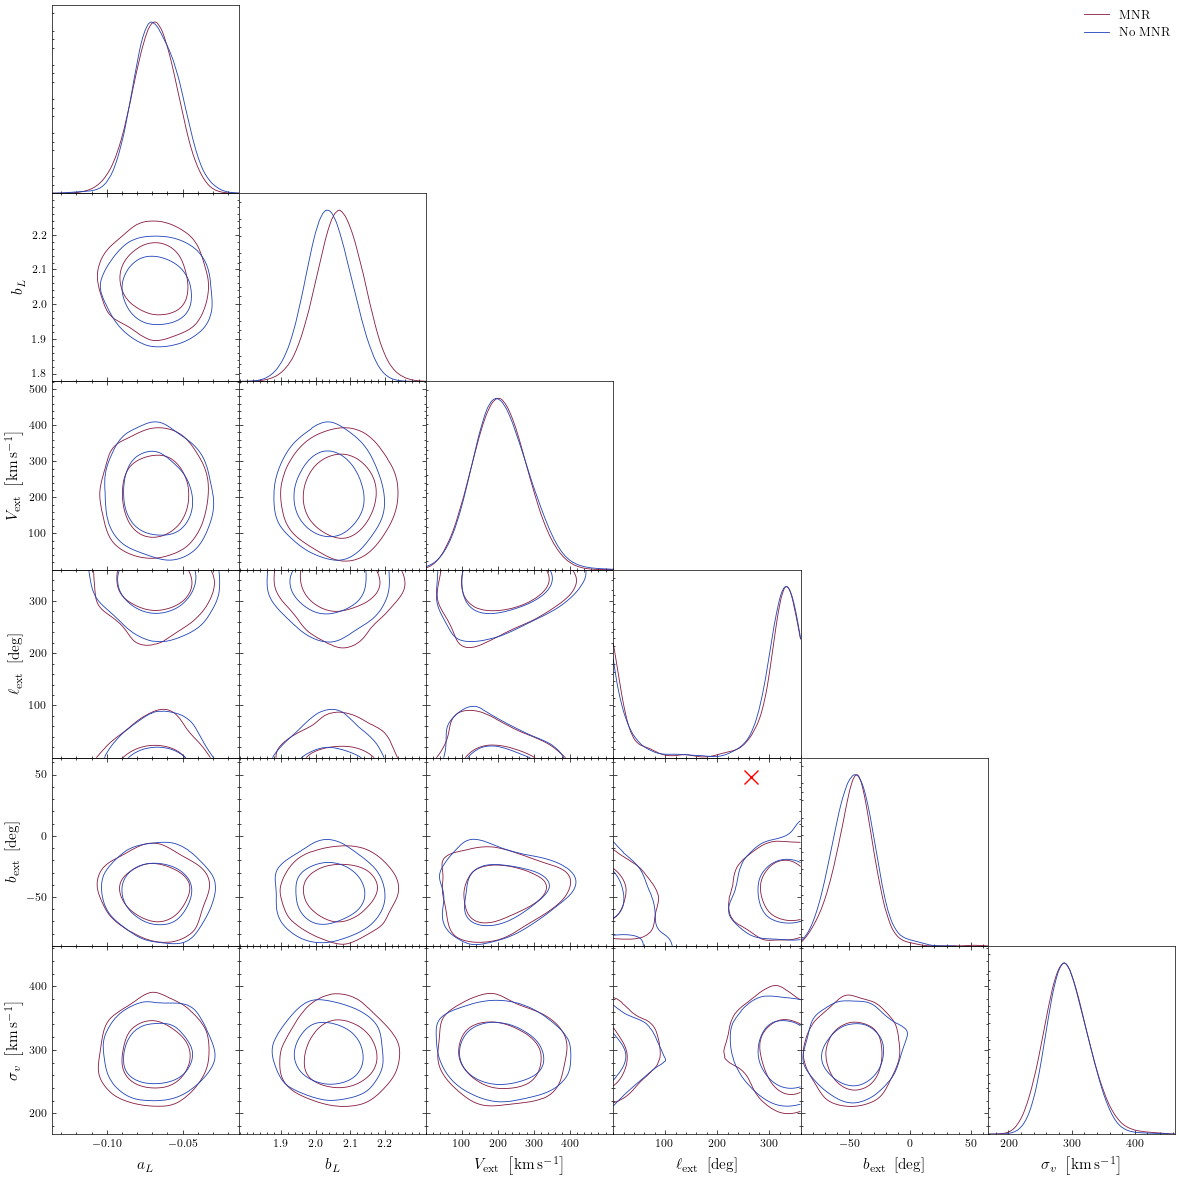

In [3]:

fnames = [
    "friday/Carrick2015_Clusters_MNR_LTYT_dipVext_hasY.hdf5",
    "friday/Carrick2015_Clusters_noMNR_LTYT_dipVext_hasY.hdf5",
    ]

cols = [
    COLS[0],COLS[1],
    "k",
    ]

labels = [
    "MNR",
    "No MNR",
    ]

fnames = [join(root, f) for f in fnames]

keys = ['A_CL','B_CL','Vext_mag','Vext_ell', 'Vext_b', 'sigma_v']

points = {("Vext_ell", "Vext_b"): (264., 48.),}

print(fnames)
plot_corner_from_hdf5(
    fnames,
    labels=labels,
    cols=cols,
    filled=False,
    points=points,
    keys=keys,
    filename="/Users/yasin/Downloads/migkas_comparison.pdf",
    )

### Dipole vs. reconstruction

['/Users/yasin/code/CANDEL/results/friday/manticore_Clusters_noMNR_LTYT_dipVext_hasY.hdf5', '/Users/yasin/code/CANDEL/results/friday/carrick2015_Clusters_noMNR_LTYT_dipVext_hasY.hdf5', '/Users/yasin/code/CANDEL/results/friday/Vext_Clusters_noMNR_LTYT_dipVext_hasY.hdf5']
manticore_Clusters_noMNR_LTYT_dipVext_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, alpha, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v
carrick2015_Clusters_noMNR_LTYT_dipVext_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, alpha, beta, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v
Vext_Clusters_noMNR_LTYT_dipVext_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v
Removed no burn in
Removed no burn in
Removed no burn in


/Users/yasin/code/CANDEL/candel/util.py:756: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


2025-10-24 18:25:22 [INFO] Saving GetDist triangle plot to: /Users/yasin/Dropbox/Apps/Overleaf/Cluster Anisotropies/Figures/reconstruction_vext.pdf


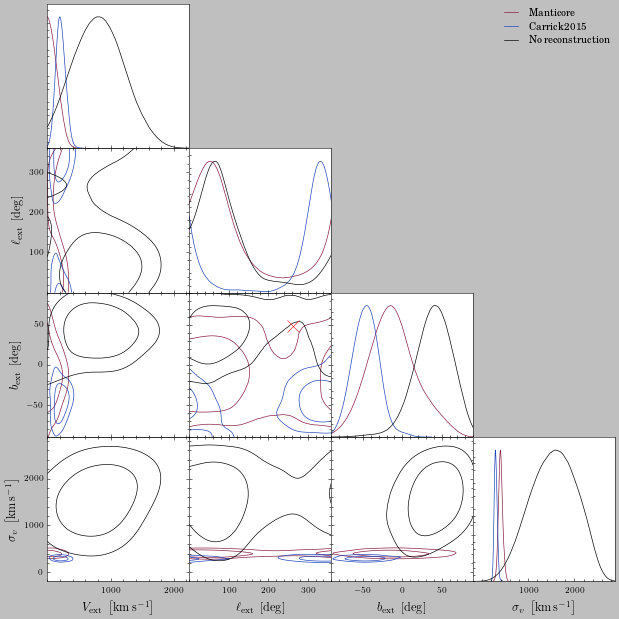

In [4]:



plt.style.use("classic")

fnames = [
    "friday/manticore_Clusters_noMNR_LTYT_dipVext_hasY.hdf5",
    "friday/carrick2015_Clusters_noMNR_LTYT_dipVext_hasY.hdf5",
    "friday/Vext_Clusters_noMNR_LTYT_dipVext_hasY.hdf5",
    ]


keys = ['Vext_mag','Vext_ell', 'Vext_b','sigma_v', ]
        #'zeropoint_dipole_mag', 'zeropoint_dipole_ell', 'zeropoint_dipole_b',

cols = [
    COLS[0],COLS[1],
    "k",
    ]

labels = [
    "Manticore",
    "Carrick2015",
    "No reconstruction",
    ]

fnames = [join(root, f) for f in fnames]

points = {("Vext_ell", "Vext_b"): (264., 48.),}

print(fnames)
to_save = figures_folder + "reconstruction_vext.pdf"

plot_corner_from_hdf5(
    fnames,
    labels=labels,
    cols=cols,
    filled=False,
    points=points,
    keys=keys,
    filename=to_save,
    legend_fontsize=40,
    )

['/Users/yasin/code/CANDEL/results/friday/manticore_Clusters_noMNR_LTYT_dipA_hasY.hdf5', '/Users/yasin/code/CANDEL/results/friday/carrick2015_Clusters_noMNR_LTYT_dipA_hasY.hdf5', '/Users/yasin/code/CANDEL/results/friday/Vext_Clusters_noMNR_LTYT_dipA_hasY.hdf5']
manticore_Clusters_noMNR_LTYT_dipA_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, alpha, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v, zeropoint_dipole_b, zeropoint_dipole_ell, zeropoint_dipole_mag
carrick2015_Clusters_noMNR_LTYT_dipA_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, b1, beta, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v, zeropoint_dipole_b, zeropoint_dipole_ell, zeropoint_dipole_mag
Vext_Clusters_noMNR_LTYT_dipA_hasY.hdf5: A2_CL, A_CL, B2_CL, B_CL, R_dist_emp, n_dist_emp, p_dist_emp, rho12, sigma_int, sigma_int2, sigma_v, zeropoint_dipole_b, zeropoint_dipole_ell, zeropoint_dipole_mag
Removed no burn in
Removed no burn in
Removed no burn in
2025-10-24 18:25:59 [INFO] Saving Get

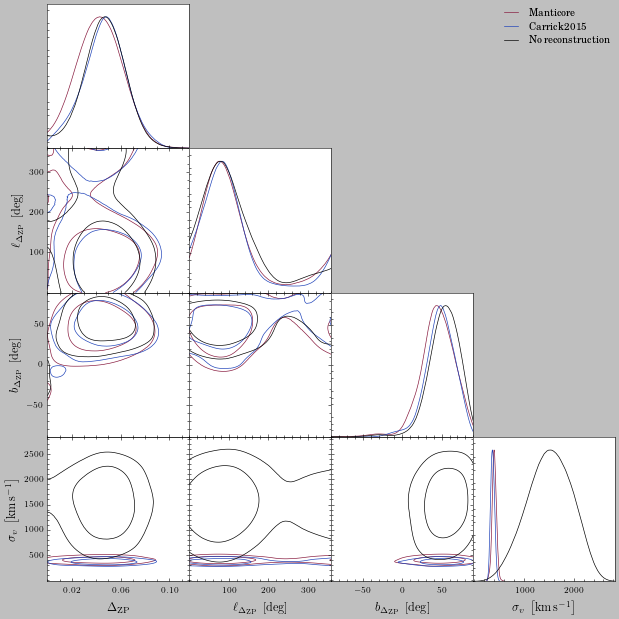

In [5]:

plt.style.use("classic")

fnames = [
    "friday/manticore_Clusters_noMNR_LTYT_dipA_hasY.hdf5",
    "friday/carrick2015_Clusters_noMNR_LTYT_dipA_hasY.hdf5",
    "friday/Vext_Clusters_noMNR_LTYT_dipA_hasY.hdf5",
    ]


keys = ['zeropoint_dipole_mag', 'zeropoint_dipole_ell', 'zeropoint_dipole_b','sigma_v']

cols = [
    COLS[0],COLS[1],
    "k",
    ]

labels = [
    "Manticore",
    "Carrick2015",
    "No reconstruction",
    ]

fnames = [join(root, f) for f in fnames]

points = {("Vext_ell", "Vext_b"): (264., 48.),}

print(fnames)

to_save = figures_folder + "reconstruction_H0.pdf"
plot_corner_from_hdf5(
    fnames,
    labels=labels,
    cols=cols,
    filled=False,
    points=points,
    keys=keys,
    filename= to_save,
    legend_fontsize=40,
    )

### Compare Migkas and my model

['/Users/yasin/code/CANDEL/results/Migkas_comparison/Migkas_Clusters_noMNR_linear_LT.hdf5', '/Users/yasin/code/CANDEL/results/Migkas_comparison/Vext_Clusters_noMNR_linear_LT.hdf5', '/Users/yasin/code/CANDEL/results/Migkas_comparison/precomputed_los_Carrick2015_Clusters_noMNR_linear_LT.hdf5']
Migkas_Clusters_noMNR_linear_LT.hdf5: A_CL, B_CL, Vext, Vext_b, Vext_ell, Vext_mag, sigma_int
Vext_Clusters_noMNR_linear_LT.hdf5: A_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, n_dist_emp, p_dist_emp, sigma_int, sigma_v
precomputed_los_Carrick2015_Clusters_noMNR_linear_LT.hdf5: A_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, b1, beta, n_dist_emp, p_dist_emp, sigma_int, sigma_v
Removed no burn in
Removed no burn in
Removed no burn in


/Users/yasin/code/CANDEL/candel/util.py:756: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


2025-10-24 18:26:16 [INFO] Saving GetDist triangle plot to: /Users/yasin/Downloads/migkas_comparison.pdf


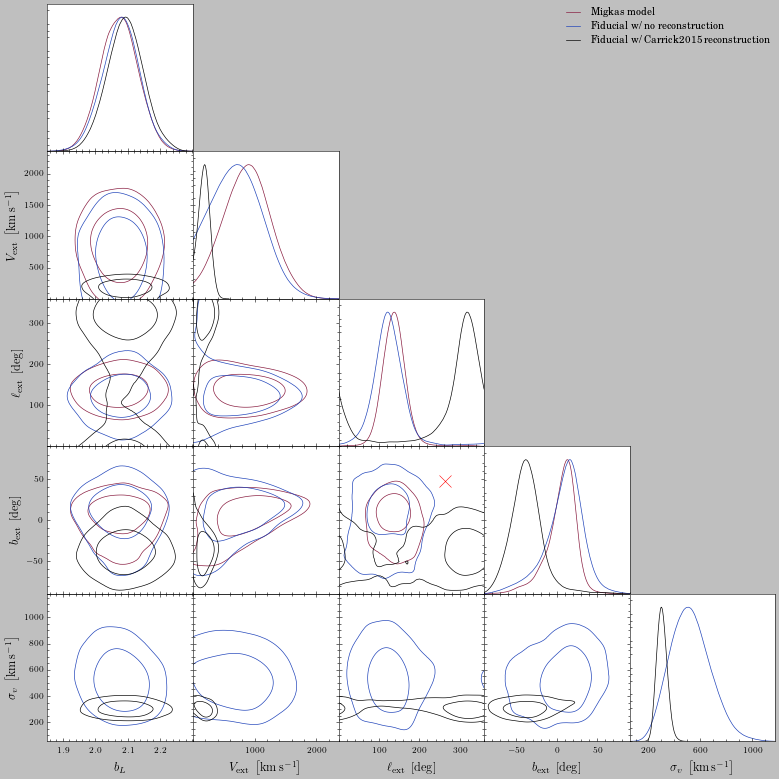

In [6]:
plt.style.use("classic")

fnames = [
    "Migkas_comparison/Migkas_Clusters_noMNR_linear_LT.hdf5",
    "Migkas_comparison/Vext_Clusters_noMNR_linear_LT.hdf5",
    "Migkas_comparison/precomputed_los_Carrick2015_Clusters_noMNR_linear_LT.hdf5"
    ]

cols = [
    COLS[0],COLS[1],
    "k",
    ]

labels = [
    "Migkas model",
    "Fiducial w/ no reconstruction",
    "Fiducial w/ Carrick2015 reconstruction",
    ]

fnames = [join(root, f) for f in fnames]

keys = ['B_CL','Vext_mag','Vext_ell', 'Vext_b', 'sigma_v']

points = {("Vext_ell", "Vext_b"): (264., 48.),}

print(fnames)
plot_corner_from_hdf5(
    fnames,
    labels=labels,
    cols=cols,
    filled=False,
    points=points,
    keys=keys,
    filename="/Users/yasin/Downloads/migkas_comparison.pdf",
    )

### Figure: LT vs. LTY

['/Users/yasin/code/CANDEL/results/LT_vs_LTY/precomputed_los_Carrick2015_Clusters_noMNR_LT_Vext_hasY.hdf5', '/Users/yasin/code/CANDEL/results/LT_vs_LTY/precomputed_los_Carrick2015_Clusters_noMNR_LTY_Vext_hasY.hdf5']
/Users/yasin/code/CANDEL/results/LT_vs_LTY/precomputed_los_Carrick2015_Clusters_noMNR_LT_Vext_hasY.hdf5
precomputed_los_Carrick2015_Clusters_noMNR_LT_Vext_hasY.hdf5: A_CL, B_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, b1, beta, n_dist_emp, p_dist_emp, sigma_int, sigma_v
/Users/yasin/code/CANDEL/results/LT_vs_LTY/precomputed_los_Carrick2015_Clusters_noMNR_LTY_Vext_hasY.hdf5
precomputed_los_Carrick2015_Clusters_noMNR_LTY_Vext_hasY.hdf5: A_CL, B_CL, C_CL, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, b1, beta, n_dist_emp, p_dist_emp, sigma_int, sigma_v
Removed no burn in
Removed no burn in


/Users/yasin/code/CANDEL/candel/util.py:544: UserWarning: scienceplots not found, using default plotting style.
  warn("scienceplots not found, using default plotting style.")
/Users/yasin/code/CANDEL/candel/util.py:657: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


2025-09-19 15:10:02 [INFO] Saving GetDist triangle plot to: /Users/yasin/Downloads/LT_vs_LTY.pdf


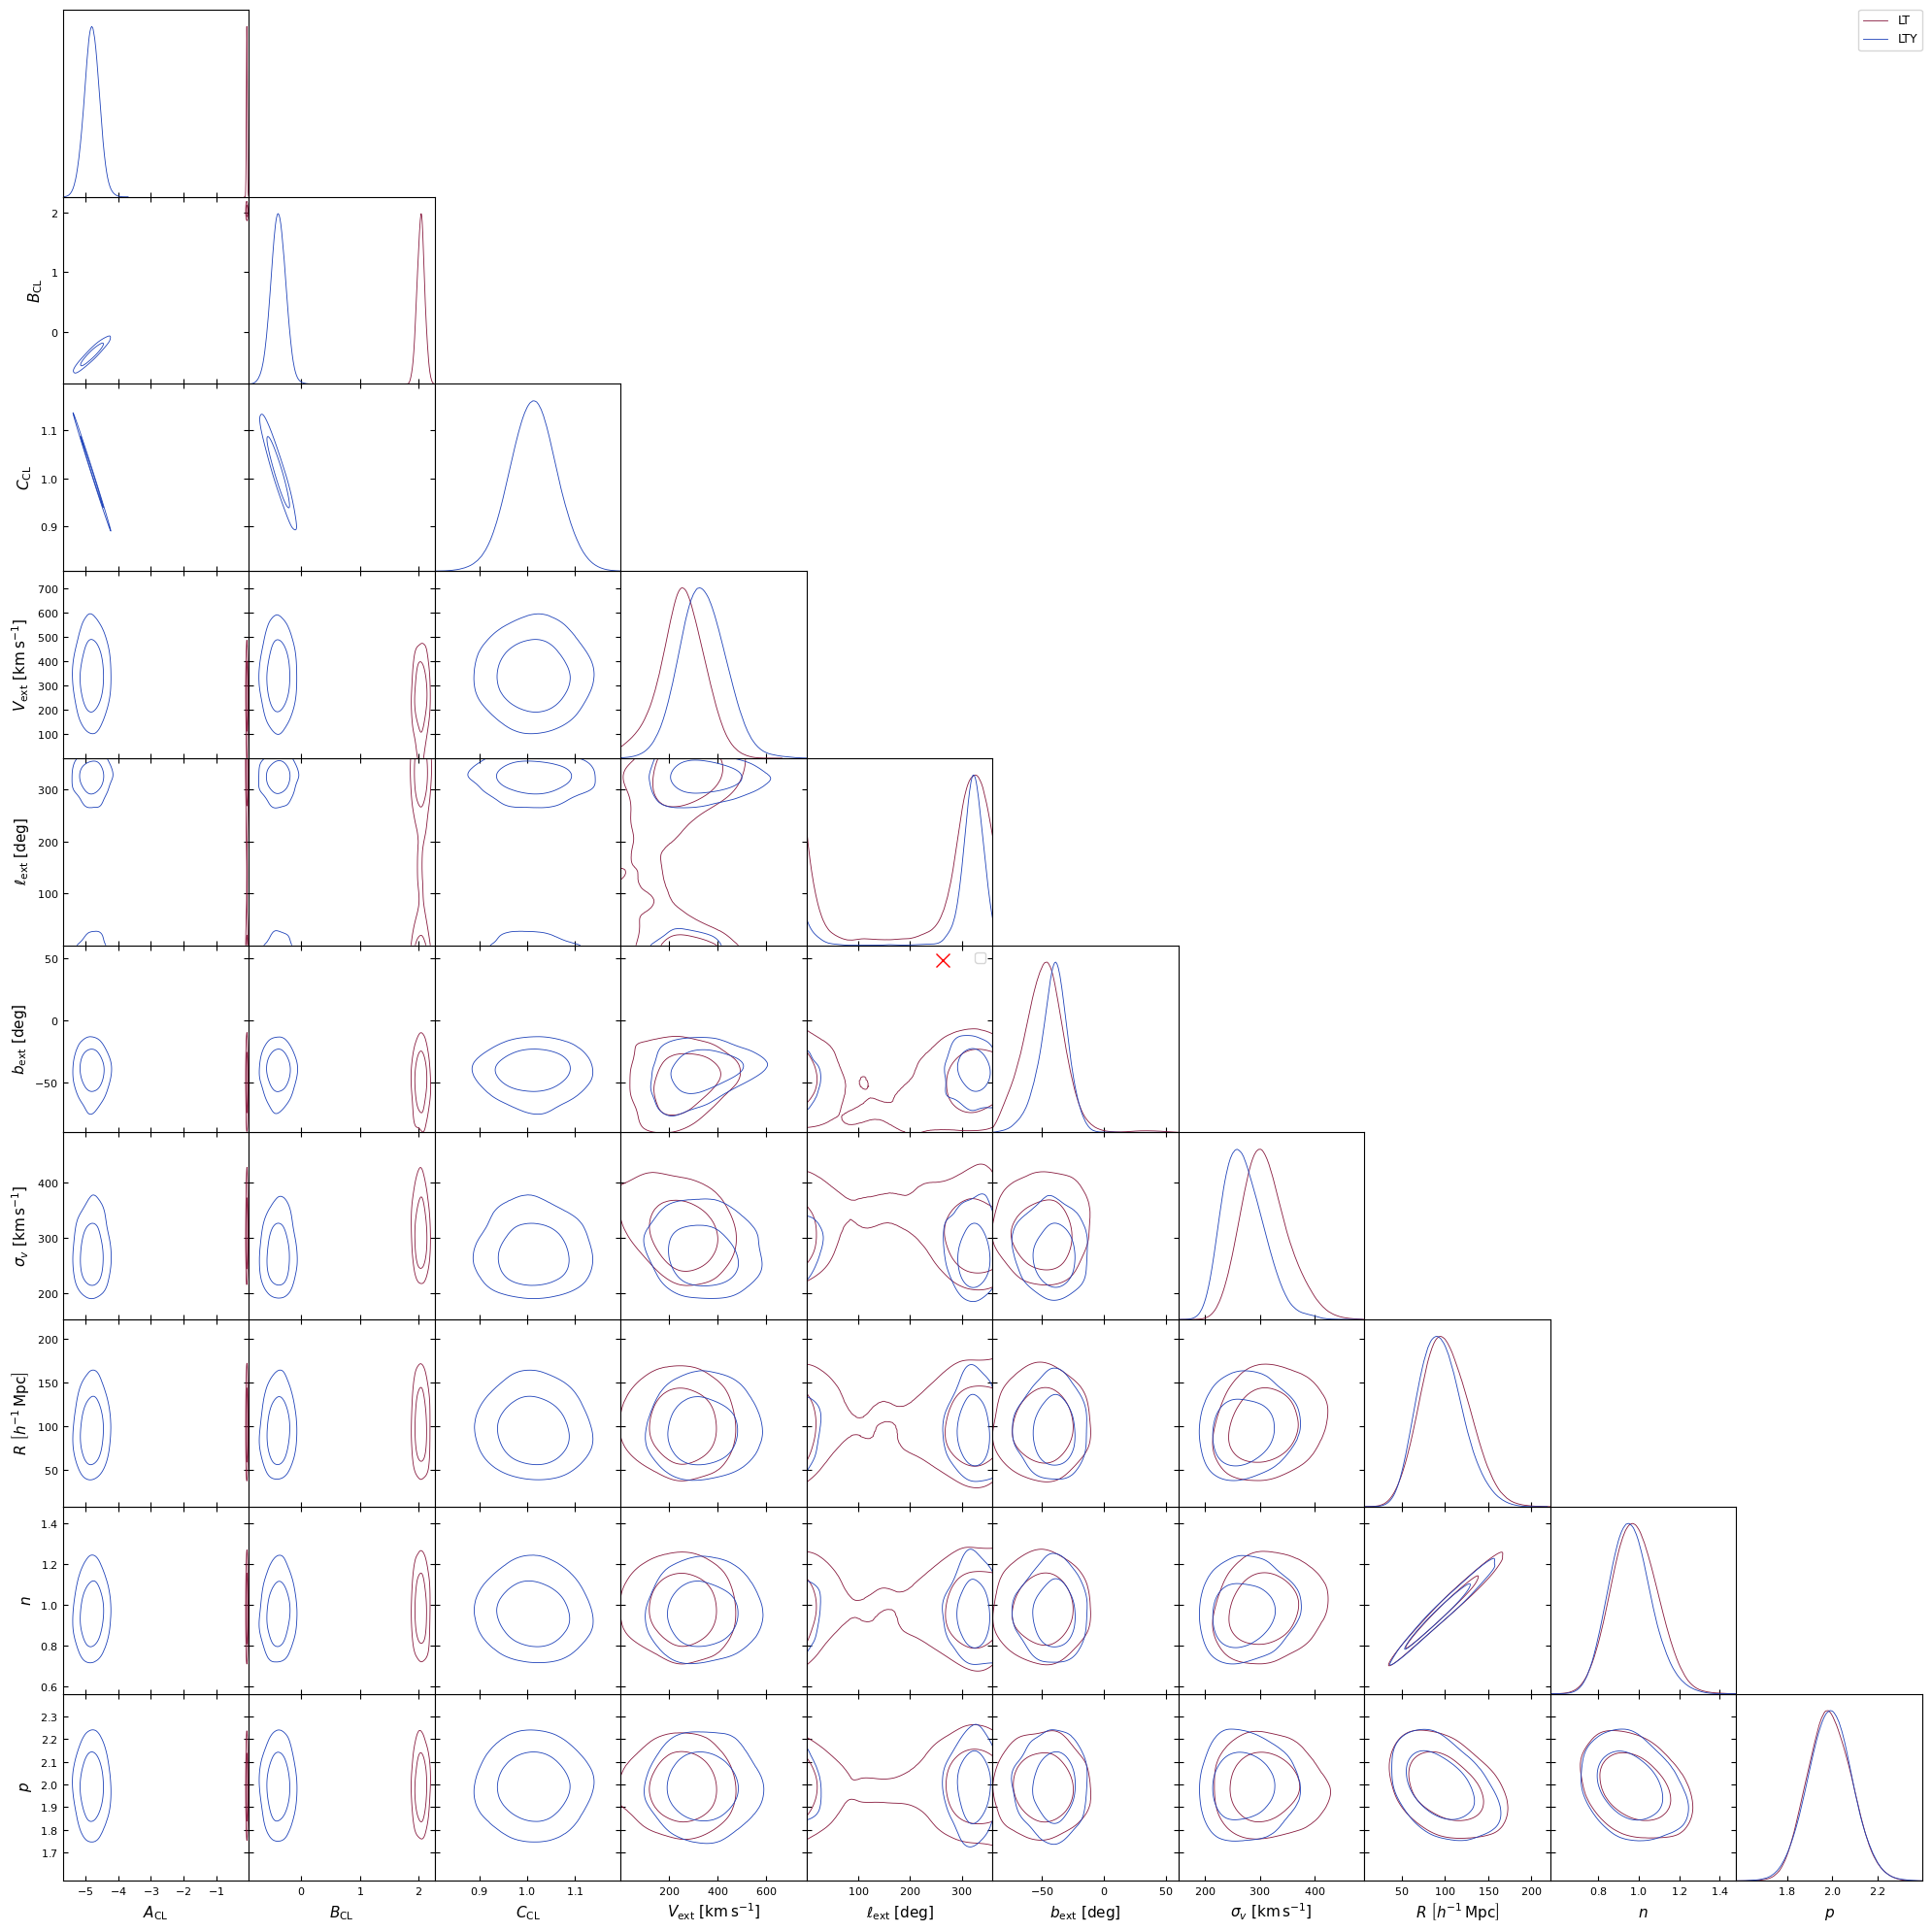

In [23]:
plt.style.use("classic")

fnames = [
    "LT_vs_LTY/precomputed_los_Carrick2015_Clusters_noMNR_LT_Vext_hasY.hdf5",
    "LT_vs_LTY/precomputed_los_Carrick2015_Clusters_noMNR_LTY_Vext_hasY.hdf5",
    ]

cols = [
    COLS[0],COLS[1],
    "k",
    ]

labels = [
    'LT',
    'LTY',
    ]

fnames = [join(root, f) for f in fnames]

print(fnames)


keys = ['A_CL','B_CL','C_CL','Vext_mag','Vext_ell', 'Vext_b', 'sigma_v',
        'R_dist_emp','n_dist_emp', 'p_dist_emp']

points = {("Vext_ell", "Vext_b"): (264., 48.),}

plot_corner_from_hdf5(
    fnames,
    labels=labels,
    cols=cols,
    filled=False,
    points=points,
    keys=keys,
    filename="/Users/yasin/Downloads/LT_vs_LTY.pdf",
    )

### Figure: Zoom-in on the magnitude dipole

In [2]:
fnames = [
    "precomputed_los_Carrick2015_CF4_W1_MNR.hdf5",
    "precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole.hdf5",
    "precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole_dust-SFD.hdf5",
    "precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole_dust-CSFD.hdf5",
    "precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole_dust-Planck2016.hdf5",
    ]

labels = [
    "Isotropic (fiducial dust model)",
    "Dipole (fiducial dust model)",
    "Dipole (dust Schlegel+1998)",
    "Dipole (dust Chiang+2023)",
    "Dipole (dust Planck 2016)",
    ]

cols = [
    "k",
    COLS[0],
    COLS[1],
    COLS[2],
    COLS[3],
]

fnames = [join(root, "precomputed_los_" + f) for f in fnames]

#points = {("zeropoint_dipole_ell", "zeropoint_dipole_b"): (272 - 180, -28)}

plot_corner_from_hdf5(
    fnames,
    fontsize=18,
    filled=False,
    labels=labels,
    cols=cols,
    keys=["zeropoint_dipole_mag", "zeropoint_dipole_ell", "zeropoint_dipole_b", "sigma_v", "sigma_int",],
    filename="/Users/rstiskalek/Downloads/C15_mag_dipole.pdf",
    # points=points,
    )

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/yasin/code/CANDEL/results_test/precomputed_los_precomputed_los_Carrick2015_CF4_W1_MNR.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Figure: Dipole prior dependence

In [ ]:
fnames = [
    "precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole.hdf5",
    "precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole_UnifComponents.hdf5",
    ]

labels = [
    "Uniform in magnitude",
    "Uniform in components",
    # "Dipole",
    # "Dipole + dust (Schlegel+1998)",
    # "Dipole + dust (Schlafly \& Finkbeiner 2011)",
    # "Dipole + dust (Planck)",
    ]

fnames = [join(root, "precomputed_los_" + f) for f in fnames]

plot_corner_from_hdf5(
    fnames,
    fontsize=20,
    filled=False,
    labels=labels,
    keys=["zeropoint_dipole_mag", "zeropoint_dipole_ell", "zeropoint_dipole_b",],
    filename="/Users/rstiskalek/Downloads/dipole_prior_dependence.pdf",
    )

### Figure: Dipoles in CF4, 2MTF, SFI++, Pantheon+

In [ ]:
fnames = [
    "precomputed_los_Carrick2015_CF4_W1_MNR_zeropoint_dipole.hdf5",
    "precomputed_los_Carrick2015_SFI_MNR_zeropoint_dipole.hdf5",
    "precomputed_los_Carrick2015_2MTF_MNR_zeropoint_dipole.hdf5",
    "precomputed_los_Carrick2015_PantheonPlus_MNR_zeropoint_dipole.hdf5",
    "precomputed_los_Carrick2015_PantheonPlusLane_MNR_zeropoint_dipole.hdf5",
    ]

labels = [
    "CF4 TFR W1",
    "SFI++",
    "2MTF",
    "Pantheon+",
    "Pantheon+Lane",
]

cols = ["k",
        COLS[0],
        COLS[1],
        COLS[2],
        COLS[3],
        ]

fnames = [join(root, "precomputed_los_" + f) for f in fnames]

plot_corner_from_hdf5(
    fnames,
    labels=labels,
    cols=cols,
    fontsize=18,
    keys=["zeropoint_dipole_mag", "zeropoint_dipole_ell", "zeropoint_dipole_b",],
    filled=True,
    filename="/Users/rstiskalek/Downloads/C15_all_TFR.pdf",
    )

### Figure: Literature direction comparison

In [ ]:

def circ_percentiles_deg(a, qs=(16, 50, 84)):
    """Circular percentiles on [0, 360) with NaN robustness."""
    a = np.asarray(a).ravel() % 360.0
    a = a[~np.isnan(a)]
    if a.size == 0:
        return np.array([np.nan, np.nan, np.nan])

    ang = np.deg2rad(a)
    c = np.nanmean(np.cos(ang))
    s = np.nanmean(np.sin(ang))
    mu = (np.rad2deg(np.arctan2(s, c)) + 360.0) % 360.0

    # unwrap around mean direction to [-180, 180)
    x = ((a - mu + 180.0) % 360.0) - 180.0
    p = np.nanpercentile(x, qs)
    return (mu + p) % 360.0


def _plot_linear_whisker(ax, med, lo, hi, y, color, lw):
    if np.isnan(med) or np.isnan(lo) or np.isnan(hi):
        return
    ax.errorbar(
        med, y,
        xerr=[[med - lo], [hi - med]],
        fmt="none",
        ecolor=color,
        elinewidth=1.5 * lw,
        capsize=5,
        zorder=2,
    )


def _plot_circ_whisker(ax, med, lo, hi, y, color, lw, cap_frac=0.12):
    """Whisker on [0,360): draws proper caps when interval wraps."""
    if np.isnan(med) or np.isnan(lo) or np.isnan(hi):
        return

    med = float(med % 360.0)
    lo = float(lo % 360.0)
    hi = float(hi % 360.0)

    # unwrap ends around median (shortest arc)
    lo_u = ((lo - med + 180.0) % 360.0) - 180.0
    hi_u = ((hi - med + 180.0) % 360.0) - 180.0
    if lo_u > hi_u:
        lo_u, hi_u = hi_u, lo_u
    lo_abs = (med + lo_u) % 360.0
    hi_abs = (med + hi_u) % 360.0

    lw_err = 1.5 * lw
    cap_h  = cap_frac  # vertical half-height of end-caps in y-data units

    if lo_abs <= hi_abs:
        # simple case: no wrap -> use errorbar (gets caps automatically)
        ax.errorbar(
            med, y,
            xerr=[[med - lo_abs], [hi_abs - med]],
            fmt="none",
            ecolor=color,
            elinewidth=lw_err,
            capsize=5,
            zorder=2,
        )
    else:
        # wrap case: draw two segments + explicit end-caps
        ax.hlines(y, 0.0,   hi_abs,  colors=color, linewidth=lw_err, zorder=2)
        ax.hlines(y, lo_abs, 360.0,  colors=color, linewidth=lw_err, zorder=2)

        # end-caps as short vertical ticks at the two ends
        ax.vlines(hi_abs, y - cap_h, y + cap_h, colors=color, linewidth=lw_err, zorder=3)
        ax.vlines(lo_abs, y - cap_h, y + cap_h, colors=color, linewidth=lw_err, zorder=3)


def _fill_circ_band(ax, med, lo, hi, color, alpha=0.15, zorder=-3):
    if np.isnan(med) or np.isnan(lo) or np.isnan(hi):
        return

    med = float(med % 360.0)
    lo = float(lo % 360.0)
    hi = float(hi % 360.0)

    lo_u = ((lo - med + 180.0) % 360.0) - 180.0
    hi_u = ((hi - med + 180.0) % 360.0) - 180.0
    if lo_u > hi_u:
        lo_u, hi_u = hi_u, lo_u
    lo_abs = (med + lo_u) % 360.0
    hi_abs = (med + hi_u) % 360.0

    if lo_abs <= hi_abs:
        ax.axvspan(lo_abs, hi_abs, color=color, alpha=alpha, zorder=zorder)
    else:
        ax.axvspan(0.0, hi_abs, color=color, alpha=alpha, zorder=zorder)
        ax.axvspan(lo_abs, 360.0, color=color, alpha=alpha, zorder=zorder)


def _pad(xlo, xhi, frac=0.08):
    d = xhi - xlo
    d = d if np.isfinite(d) and d > 0 else 1.0
    return xlo - frac * d, xhi + frac * d


# ===================== load samples =====================

keys = ["zeropoint_dipole_mag", "zeropoint_dipole_ell", "zeropoint_dipole_b"]
S = [read_samples(root, f, keys=keys) for f in fnames]

mag_samps = [np.asarray(s["zeropoint_dipole_mag"]).ravel() for s in S]
ell_samps = [np.asarray(s["zeropoint_dipole_ell"]).ravel() % 360.0 for s in S]
b_samps   = [np.asarray(s["zeropoint_dipole_b"]).ravel() for s in S]

# ===================== summarise =====================

mag_q = np.array([np.nanpercentile(s, [16, 50, 84]) for s in mag_samps])
b_q   = np.array([np.nanpercentile(s, [16, 50, 84]) for s in b_samps])
ell_q = np.array([circ_percentiles_deg(s) for s in ell_samps])

mag_med, mag_lo, mag_hi = mag_q[:, 1], mag_q[:, 0], mag_q[:, 2]
b_med,   b_lo,   b_hi   = b_q[:, 1],   b_q[:, 0],   b_q[:, 2]
ell_med, ell_lo, ell_hi = ell_q[:, 1], ell_q[:, 0], ell_q[:, 2]

# ===================== y positions =====================

n = len(labels)
y = np.arange(n - 1, -1, -1)  # top -> bottom

# ===================== literature (placeholders) =====================

# Each item: (label, mag_mu, mag_sigma, ell_mu_deg, ell_sigma_deg, b_mu_deg, b_sigma_deg)
lit_col = "#e4ba0c"
literature = [
    ("Boubel+2024", 0.063, 0.016, 142.0, 30,  52,  10),
    ("Secrest+2022", None, None, 217, 10.0,  20, 7),
    ("Migkas+2021\n(opposite)", None, None, 280 - 180, 35,  (-1) * -15, 20),
    ("Watkins+2023\n(opposite)", None, None, 297 - 180, 4,  (-1) * -6, 3),
    ("Sorrenti+2023\n(opposite)", None, None, 207 - 180, 73, (-1) * 49, 20)
]

# precompute where the literature rows will sit
lit_base = -1  # start just below 0
lit_positions = [(lit_base - j, lab) for j, (lab, *_vals) in enumerate(literature)]

# ===================== figure =====================

fig_w, fig_h = 7.9, 3.0 + 0.2 * (n + len(literature))
with plt.style.context("science"):
    fig, (ax_mag, ax_ell, ax_b) = plt.subplots(
        1, 3, figsize=(fig_w, fig_h), sharey=True
    )
    lw = plt.rcParams["lines.linewidth"]

    # Force yticks/labels on the left (sharey=True suppresses them otherwise)
    ax_mag.tick_params(which="both", left=True, labelleft=True)
    ax_ell.tick_params(labelleft=False)
    ax_b.tick_params(labelleft=False)

    # ===== shaded bands for fiducial (CF4 W1) =====
    fid_idx = [i for i, lab in enumerate(labels) if ("CF4" in lab and "W1" in lab)]
    if not fid_idx:
        raise ValueError("Could not find fiducial 'CF4'+'W1' in labels.")
    fid_idx = fid_idx[0]
    fid_col = cols[fid_idx]

    ax_mag.axvspan(mag_lo[fid_idx], mag_hi[fid_idx],
                   color=fid_col, alpha=0.15, zorder=-3)
    _fill_circ_band(ax_ell, ell_med[fid_idx], ell_lo[fid_idx], ell_hi[fid_idx],
                    color=fid_col, alpha=0.15, zorder=-3)
    ax_b.axvspan(b_lo[fid_idx], b_hi[fid_idx],
                 color=fid_col, alpha=0.15, zorder=-3)

    # ===== whiskers: datasets =====
    for i in range(n):
        _plot_linear_whisker(ax_mag, mag_med[i], mag_lo[i], mag_hi[i],
                             y[i], cols[i], lw)
        _plot_circ_whisker(ax_ell, ell_med[i], ell_lo[i], ell_hi[i],
                           y[i], cols[i], lw)
        _plot_linear_whisker(ax_b, b_med[i], b_lo[i], b_hi[i],
                             y[i], cols[i], lw)

    # ===== literature block (below) =====
    for (ypos, lab), (_lab, m_mu, m_sig, l_mu, l_sig, bb_mu, bb_sig) in zip(
        lit_positions, literature
    ):
        if m_mu is not None:
            _plot_linear_whisker(ax_mag, m_mu, m_mu - m_sig, m_mu + m_sig,
                                 ypos, lit_col, lw)
        _plot_circ_whisker(ax_ell, l_mu, l_mu - l_sig, l_mu + l_sig,
                           ypos, lit_col, lw)
        _plot_linear_whisker(ax_b, bb_mu, bb_mu - bb_sig, bb_mu + bb_sig,
                             ypos, lit_col, lw)

    # separator between "This work" and "Literature"
    sep_y = lit_base + 0.5
    for ax in [ax_mag, ax_b, ax_ell]:
        ax.axhline(sep_y, color="black", lw=lw * 1.5, ls="--", zorder=-5)

    # ===== y ticks/labels on left panel only =====
    yticks = list(y) + [yp for yp, _ in lit_positions]
    ylabels = list(labels) + [lab for _, lab in lit_positions]
    ax_mag.set_yticks(yticks)
    ax_mag.set_yticklabels(ylabels)

    # Block labels
    ax_mag.text(0.05, 0.97, "This work", ha="left", va="top",
                transform=ax_mag.transAxes,
                bbox=dict(facecolor="white", edgecolor="black",
                          boxstyle="square,pad=0.3"))

    ax_mag.text(0.05,
                (sep_y - (lit_base - len(literature))) / (n + len(literature) + 1) - 1.3,
                "Literature", ha="left", va="top",
                transform=ax_mag.get_yaxis_transform(),
                bbox=dict(facecolor="white", edgecolor="black",
                          boxstyle="square,pad=0.3", linewidth=0.8))

    ax_mag.set_xlabel(r"$\Delta_{\rm ZP}~[\mathrm{mag}]$")
    ax_ell.set_xlabel(r"$\ell~[\mathrm{deg}]$")
    ax_b.set_xlabel(r"$b~[\mathrm{deg}]$")

    ax_mag.minorticks_off()
    ax_ell.minorticks_off()
    ax_b.minorticks_off()

    # collect all mag limits from datasets
    mag_all = list(mag_lo) + list(mag_hi)

    # add literature, but skip if mean or sigma is None
    for _, m, s, *_ in literature:
        if m is not None and s is not None:
            mag_all.extend([m - s, m + s])

    mag_lims = _pad(np.nanmin(mag_all), np.nanmax(mag_all))

    mag_lims = (0, mag_lims[1])  # force mag-lims to start at 0
    b_lims = _pad(
        np.nanmin(np.r_[b_lo,   [b - s for *_, b, s in literature]]),
        np.nanmax(np.r_[b_hi,   [b + s for *_, b, s in literature]]),
    )
    ax_mag.set_xlim(*mag_lims)
    ax_ell.set_xlim(0, 360)
    ax_b.set_xlim(*b_lims)

    # shared y-lims to include literature rows
    ymin = lit_base - len(literature) - 0.1
    ymax = n - 0.1
    ax_mag.set_ylim(ymin, ymax)
    ax_ell.set_ylim(ymin, ymax)
    ax_b.set_ylim(ymin, ymax)

    fig.tight_layout(w_pad=1.0)
    plt.savefig(
        "/Users/rstiskalek/Downloads/zeropoint_dipole_stacked.pdf",
        dpi=500,
    )
    plt.show()

### Figure: Evidence as a function of the sample size

In [4]:
mock_dir = join(root, "CF4_mock_anisotropic")

In [8]:
!ls /Users/rstiskalek/Projects/CANDEL/results/dH0/CF4_mock_anisotropic

precomputed_los_Carrick2015_CF4_mock_0_MNR.hdf5
precomputed_los_Carrick2015_CF4_mock_0_MNR.png
precomputed_los_Carrick2015_CF4_mock_0_MNR.toml
precomputed_los_Carrick2015_CF4_mock_0_MNR_zeropoint_dipole.hdf5
precomputed_los_Carrick2015_CF4_mock_0_MNR_zeropoint_dipole.png
precomputed_los_Carrick2015_CF4_mock_0_MNR_zeropoint_dipole.toml
precomputed_los_Carrick2015_CF4_mock_10_MNR.hdf5
precomputed_los_Carrick2015_CF4_mock_10_MNR.png
precomputed_los_Carrick2015_CF4_mock_10_MNR.toml
precomputed_los_Carrick2015_CF4_mock_10_MNR_zeropoint_dipole.hdf5
precomputed_los_Carrick2015_CF4_mock_10_MNR_zeropoint_dipole.png
precomputed_los_Carrick2015_CF4_mock_10_MNR_zeropoint_dipole.toml
precomputed_los_Carrick2015_CF4_mock_11_MNR.hdf5
precomputed_los_Carrick2015_CF4_mock_11_MNR.png
precomputed_los_Carrick2015_CF4_mock_11_MNR.toml
precomputed_los_Carrick2015_CF4_mock_11_MNR_zeropoint_dipole.hdf5
precomputed_los_Carrick2015_CF4_mock_11_MNR_zeropoint_dipole.png
precomputed_los_Carrick2015_CF4_mock_11_MNR

In [39]:
def load_mock_fnames(which):
    mock_dir = f"/Users/rstiskalek/Projects/CANDEL/results/dH0/CF4_mock_{which}"
    records = np.loadtxt(
        f"/Users/rstiskalek/Projects/CANDEL/data/CF4_mock/{which}/mock_index.txt",
        dtype=int, comments='#'
    )
    indices, nsamples = records[:, 0], records[:, 1]

    fnames = [
        join(mock_dir, f"precomputed_los_Carrick2015_CF4_mock_{i}_MNR_zeropoint_dipole.hdf5")
        for i in indices]
    N = len(fnames)

    # Keep only files that exist
    mask = np.array([exists(f) for f in fnames])
    fnames = [f for f, m in zip(fnames, mask) if m]
    print(f"Expected {N} files, found {len(fnames)}")

    return fnames, nsamples[mask]




Expected 70 files, found 48
Expected 70 files, found 44


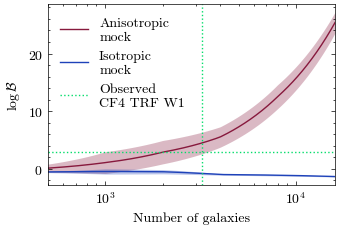

In [85]:
from scipy.interpolate import make_interp_spline

# anisotropic
fnames_a, nsamples_a = load_mock_fnames("anisotropic")
# isotropic
fnames_i, nsamples_i = load_mock_fnames("isotropic")

metric = "logZ_harmonic"
real_data_logB = 2.938

with plt.style.context(["science", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.6, 2.5))
    lw = plt.rcParams["lines.linewidth"]

    def stats(fnames, nsamples):
        gof = np.asarray([compare_zeropoint_dipole_gof(f, metric, verbose=False)
                          for f in fnames])
        ns = np.asarray(nsamples)
        xs, mu, sig = [], [], []
        for n in np.sort(np.unique(ns)):
            vals = gof[ns == n]
            if np.isfinite(vals).any():
                xs.append(n)
                mu.append(np.nanmean(vals))
                sig.append(np.nanstd(vals))
        return np.asarray(xs), np.asarray(mu), np.asarray(sig)

    def plot_band(xs, mu, sig, color, label):
        if xs.size == 0:
            return
        if xs.size >= 2:
            xnew = np.logspace(np.log10(xs.min()), np.log10(xs.max()), 300)
            # k = min(3, xs.size - 1)
            k = 1
            try:
                mu_s  = make_interp_spline(xs, mu,  k=k)(xnew)
                sig_s = make_interp_spline(xs, sig, k=k)(xnew)
                ax.plot(xnew, mu_s, lw=lw, color=color, label=label)
                ax.fill_between(xnew, mu_s - sig_s, mu_s + sig_s,
                                alpha=0.3, lw=0, color=color)
                return
            except Exception:
                pass
        # fallback
        ax.plot(xs, mu, lw=lw, color=color, label=label)
        ax.fill_between(xs, mu - sig, mu + sig, alpha=0.3, lw=0, color=color)

    # compute and plot
    xs_a, mu_a, sig_a = stats(fnames_a, nsamples_a)
    xs_i, mu_i, sig_i = stats(fnames_i, nsamples_i)

    if xs_a.size == 0 and xs_i.size == 0:
        raise RuntimeError("No finite values to plot for either set.")

    plot_band(xs_a, mu_a, sig_a, color=COLS[0], label="Anisotropic\nmock")
    plot_band(xs_i, mu_i, sig_i, color=COLS[1], label="Isotropic\nmock")

    # horizontal refs
    c_data = COLS[-2]
    ax.axhline(real_data_logB, linestyle="dotted", lw=lw, color=c_data,
               label="Observed\nCF4 TRF W1")

    # optional vertical ref at 3250 if inside either range
    xmins = [x.min() for x in (xs_a, xs_i) if x.size]
    xmaxs = [x.max() for x in (xs_a, xs_i) if x.size]
    if xmins and xmaxs and (min(xmins) < 3233 < max(xmaxs)):
        ax.axvline(3233, linestyle="dotted", lw=lw, color=c_data)

    ax.set_xlabel("Number of galaxies")
    ax.set_ylabel(r"$\log \mathcal{B}$")
    ax.set_xlim(nsamples_a.min(), nsamples_a.max())
    ax.set_xscale("log")
    ax.legend()

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/evidence_comparison.pdf", dpi=450)
    plt.show()